<a href="https://colab.research.google.com/github/jdasam/ant5015/blob/2024F/notebooks/6_automatic_music_transcription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Download Dataset

In [1]:
!gdown --id 1L99FSzloXGQsmc-OwsVKggvQNF9niN2M
!unzip -q maestro_small.zip


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1L99FSzloXGQsmc-OwsVKggvQNF9niN2M
From (redirected): https://drive.google.com/uc?id=1L99FSzloXGQsmc-OwsVKggvQNF9niN2M&confirm=t&uuid=078e6263-d3cd-4010-8507-4615e1118654
To: /content/maestro_small.zip
100% 1.14G/1.14G [00:18<00:00, 62.7MB/s]


In [2]:
!pip install mido pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 52.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.7 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=007bf0984d92310f64bc955cbdc2d76721e342dbf6550c25cb240a6ce38eab86
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


## 1. Preprocess Data

In [7]:
import json
json_path = 'data/data.json'

with open(json_path, 'r') as f:
  meta = json.load(f)
print(len(meta))
print(meta[50])

170
{'canonical_composer': 'Claude Debussy', 'canonical_title': "L'isle joyeuse", 'split': 'train', 'year': 2013, 'midi_filename': '2013/ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_12_R3_2013_wav--3.midi', 'audio_filename': '2013/ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_12_R3_2013_wav--3.wav', 'duration': 350.077107188}


In [14]:
from pathlib import Path
import IPython.display as ipd
import torchaudio

data_dir = Path('data/')
assert data_dir.exists()

info = meta[50]
audio_fn = info['audio_filename']
midi_fn = info['midi_filename']

audio_fn = (data_dir / audio_fn).with_suffix('.flac')
audio_fn.exists()

y, sr = torchaudio.load(audio_fn)

In [15]:
y.shape, sr

(torch.Size([1, 5627935]), 16000)

In [17]:
ipd.Audio(y[:, :sr*20], rate=sr)

In [21]:
from mido import Message, MidiFile, MidiTrack

midi_abs_fn = data_dir / midi_fn
assert midi_abs_fn.exists()

midi_obj = MidiFile(midi_abs_fn)
midi_obj.merged_track[:20]

MidiTrack([
  MetaMessage('set_tempo', tempo=500000, time=0),
  MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
  MetaMessage('track_name', name='7.10.13 Group 2', time=0),
  Message('program_change', channel=0, program=0, time=0),
  Message('control_change', channel=0, control=64, value=127, time=0),
  Message('control_change', channel=0, control=67, value=127, time=0),
  Message('note_on', channel=0, note=73, velocity=33, time=504),
  Message('note_on', channel=0, note=73, velocity=0, time=259),
  Message('note_on', channel=0, note=75, velocity=36, time=34),
  Message('note_on', channel=0, note=75, velocity=0, time=158),
  Message('note_on', channel=0, note=73, velocity=36, time=24),
  Message('note_on', channel=0, note=73, velocity=0, time=83),
  Message('note_on', channel=0, note=75, velocity=38, time=17),
  Message('note_on', channel=0, note=75, velocity=0, time=96),
  Message('note_on', channel=0, note=73, vel

In [40]:
cur_time = 0
entire_notes = []
temp_notes = []

for message in midi_obj.merged_track:
  cur_time += message.time / 768
  if message.type == 'note_on':
    if message.velocity > 0:
      new_note = {'note': message.note, 'velocity': message.velocity, 'onset': cur_time}
      temp_notes.append(new_note)
    else: # note offset
      delete_ids = []
      for i, tmp_nt in enumerate(temp_notes):
        if message.note == tmp_nt['note']:
          tmp_nt['offset'] = cur_time
          entire_notes.append(tmp_nt)
          delete_ids.append(i)
      for idx in reversed(delete_ids):
        temp_notes.pop(idx)
  else:
    continue

entire_notes

[{'note': 73, 'velocity': 33, 'onset': 0.65625, 'offset': 0.9934895833333333},
 {'note': 75,
  'velocity': 36,
  'onset': 1.0377604166666665,
  'offset': 1.2434895833333333},
 {'note': 73,
  'velocity': 36,
  'onset': 1.2747395833333333,
  'offset': 1.3828125},
 {'note': 75,
  'velocity': 38,
  'onset': 1.4049479166666667,
  'offset': 1.5299479166666667},
 {'note': 73,
  'velocity': 44,
  'onset': 1.5651041666666667,
  'offset': 1.6236979166666667},
 {'note': 75, 'velocity': 32, 'onset': 1.7109375, 'offset': 1.75390625},
 {'note': 73,
  'velocity': 47,
  'onset': 1.7760416666666667,
  'offset': 1.83203125},
 {'note': 75,
  'velocity': 39,
  'onset': 1.9049479166666667,
  'offset': 1.9440104166666667},
 {'note': 73,
  'velocity': 52,
  'onset': 1.9674479166666667,
  'offset': 2.014322916666667},
 {'note': 75,
  'velocity': 45,
  'onset': 2.069010416666667,
  'offset': 2.1093750000000004},
 {'note': 73,
  'velocity': 56,
  'onset': 2.130208333333334,
  'offset': 2.173177083333334},
 {'no

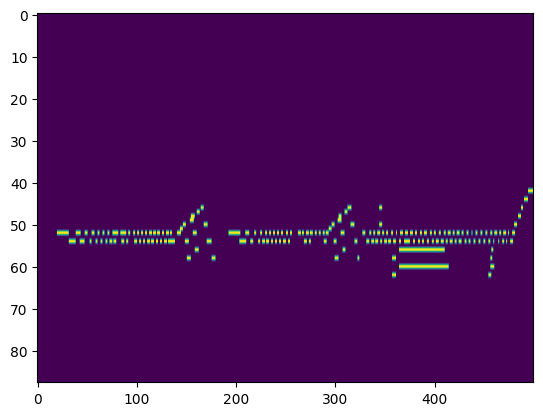

In [47]:
from math import ceil
import torch
# conver to piano roll
hop_second = 0.032
duration = info['duration']
total_num_frame = ceil(duration / hop_second)


piano_roll = torch.zeros(88, total_num_frame)

for note in entire_notes:
  pitch = note['note'] - 21
  onset_frame = int(note['onset'] // hop_second)
  offset_frame = int(note['offset'] // hop_second)
  piano_roll[pitch, onset_frame:offset_frame+1] = 1

import matplotlib.pyplot as plt

plt.imshow(piano_roll[:, :500], aspect='auto')

## 2. Model

In [ ]:
import torch.nn as nn

class SpecConverter(nn.Module):
  def __init__(self):
    super().__init__()
    self.mel = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=2048, hop_length=512, n_mels=352)
    self.db = torchaudio.transforms.AmplitudeToDB()

  def forward(self, x):
    return self.db(self.mel(x)) / 80

converter = SpecConverter()
out = converter(audio)

## 3. Training